<a href="https://colab.research.google.com/github/kartikbatra056/Deep-Learning-with-Pytorch/blob/master/Cifar_10_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import Libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

In [2]:
'''
Importing Cifar-10 data using torchvision libraries which load PILImages in range [0,1].
Converting  Images into Tensor and Normalizing Images in range [-1,1]
'''
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
 
train_data= torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)

train_loader=torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True,num_workers=2)

test_data=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

test_loader=torch.utils.data.DataLoader(test_data,batch_size=64,num_workers=2)

classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


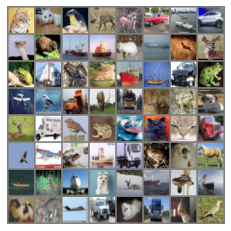

In [3]:
from matplotlib import pyplot as plt
import numpy as np

#defining Function to show image
def show_image(img):
   img=img/2+0.5
   image=img.numpy()
   plt.imshow(np.transpose(image,(1,2,0)))
   plt.axis('off')
   plt.show()
#iterable for getting random images
dataiter=iter(train_loader)
 
images,labels=dataiter.next()
#show images
show_image(torchvision.utils.make_grid(images))

In [0]:
import torch.nn as nn
import torch.nn.functional as F
 
class Neural_net(nn.Module):
    def __init__(self,num_classes=10):
    
        super(Neural_net,self).__init__()
    
        self.conv1=nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.batch1=nn.BatchNorm2d(num_features=32)
        self.relu1=nn.ReLU()

        self.conv2=nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.batch2=nn.BatchNorm2d(num_features=32)
        self.relu2=nn.ReLU()

        self.pool1=nn.MaxPool2d(kernel_size=2,stride=2)
    
        self.conv3=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.batch3=nn.BatchNorm2d(num_features=64)
        self.relu3=nn.ReLU()

        self.conv4=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.batch4=nn.BatchNorm2d(num_features=64)
        self.relu4=nn.ReLU()

        self.pool2=nn.MaxPool2d(kernel_size=2,stride=2)
        self.drop1=nn.Dropout(0.25)

        self.conv5=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1)
        self.batch5=nn.BatchNorm2d(num_features=128)
        self.relu5=nn.ReLU()

        self.conv6=nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1)
        self.batch6=nn.BatchNorm2d(num_features=128)
        self.relu6=nn.ReLU()
 
        self.pool3=nn.AvgPool2d(kernel_size=4)

        self.drop2=nn.Dropout(0.5)

        self.Neural_net=nn.Sequential(self.conv1,self.batch1,self.relu1,self.conv2,self.batch2,self.relu2,self.pool1 
                                  ,self.conv3,self.batch3,self.relu3,self.conv4,self.batch4,self.relu4,self.pool2,self.drop1,
                                  self.conv5,self.batch5,self.relu5,self.conv6,self.batch6,self.relu6,self.pool3,self.drop2)

        self.fc1=nn.Linear(in_features=128,out_features=64)
        self.relu7=nn.ReLU()
        
        self.fc2=nn.Linear(in_features=64,out_features=num_classes)
        self.softmax=nn.Softmax(dim=1)

    def forward(self,input):
      output=self.conv1(input)
      output=self.batch1(output)
      output=self.relu1(output)

      output=self.conv2(output)
      output=self.batch2(output)
      output=self.relu2(output)

      output=self.pool1(output)

      output=self.conv3(output)
      output=self.batch3(output)
      output=self.relu3(output)

      output=self.conv4(output)
      output=self.batch4(output)
      output=self.relu4(output)

      output=self.pool2(output)
      output=self.drop1(output)

      output=self.conv5(output)
      output=self.batch5(output)
      output=self.relu5(output)

      output=self.conv6(output)
      output=self.batch6(output)
      output=self.relu6(output)

      output=self.pool3(output)
      output=self.drop2(output)
     
      output=output.view(-1,1*1*128)

      output=self.fc1(output)
      output=self.relu7(output)
      
      output=self.fc2(output)
      output=self.softmax(output)

      return output

In [0]:
from torch.optim import Adam

cuda_avail=torch.cuda.is_available()

model=Neural_net(num_classes=10)

if cuda_avail:
  model.cuda()

optimizer=Adam(model.parameters(),lr=0.01)
loss_fn= nn.CrossEntropyLoss()

In [0]:
def adjust_learning_rate(epoch):
   lr=0.001

   if epoch>15:
     lr=lr/10
   elif epoch>10:
     lr=lr/6
   elif epoch>5:
     lr=lr/3  

   for param in optimizer.param_groups:
        param['lr']=lr    

In [0]:
def test():
  with torch.no_grad():
    model.eval()
    test_acc=0.0
    for i,(img,lbl) in enumerate(test_loader):

       if cuda_avail:
         img=Variable(img.cuda())
         lbl=Variable(lbl.cuda())
       outputs=model(img)
       _,prediction=torch.max(outputs.data,1)
       test_acc+=torch.sum(prediction==lbl.data)


  test_acc=test_acc/10000
  return test_acc  

In [0]:
def train(num_epochs):
    acc=0.0
    for epoch in range(num_epochs):
      model.train()
      train_acc=0.0
      train_loss=0.0
      for i,(img,lbl) in enumerate(train_loader):
      
          if cuda_avail:
            img=Variable(img.cuda())
            lbl=Variable(lbl.cuda())
      
          optimizer.zero_grad()

          outputs=model(img)

          loss=loss_fn(outputs,lbl)

          loss.backward()    

          optimizer.step()

          train_loss+=loss.cpu().data*img.size(0)
          _,prediction=torch.max(outputs.data,1)
          train_acc+=torch.sum(prediction==lbl.data)
      
          #adjust_learning_rate(epoch)

      train_acc=train_acc/50000
      train_loss=train_loss/50000

      test_acc=test()

      print("Epoch {}, Train Accuracy: {} , TrainLoss: {} , Test Accuracy: {}".format(epoch, train_acc, train_loss,test_acc))
      

In [12]:
if __name__ == "__main__":
  train(20)

Epoch 0, Train Accuracy: 0.7309199571609497 , TrainLoss: 1.7291918992996216 , Test Accuracy: 0.7621999979019165
Epoch 1, Train Accuracy: 0.7394399642944336 , TrainLoss: 1.7212074995040894 , Test Accuracy: 0.7651999592781067
Epoch 2, Train Accuracy: 0.7430799603462219 , TrainLoss: 1.717877984046936 , Test Accuracy: 0.7644000053405762
Epoch 3, Train Accuracy: 0.7488399744033813 , TrainLoss: 1.7115797996520996 , Test Accuracy: 0.767300009727478


KeyboardInterrupt: ignored